<a href="https://colab.research.google.com/github/SighOfFrostmourne/ECOM6022/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

## Environment Setup & Reading Data

### Environment Setup

In [142]:
# Python ≥3.5 and Scikit-Learn ≥0.20 are required
import sys
import sklearn
import numpy as np
import os

# To plot pretty figures (for report etc)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
ROOT_PATH = "/content/drive/MyDrive/ECOM6022/Assignment_3"
os.chdir(ROOT_PATH)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Assignment_3"
DATA_PATH = os.path.join(ROOT_PATH, "datasets")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Read the downloaed file from Google Drive

As moodle requires authorization to download the file, download link url doesn't work properly from the original coding introduced in Lecture. Thus download it and use directly.

In [143]:
import pandas as pd

def load_data(data_path=DATA_PATH):
    customer_csv_path = os.path.join(data_path, "customer_dataset.csv")
    return pd.read_csv(customer_csv_path)

customer_data = load_data() 

## Take a Quick Look at the Data Structure

In [144]:
customer_data.head()

,CustomerID,Gender,Age,income,SpendingScore
0,1,Female,28,508,89
1,2,Female,21,215,81
2,3,Female,28,294,51
3,4,Female,26,452,29
4,5,Male,57,213,4


In [145]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     200 non-null    int64 
 1   Gender         200 non-null    object
 2   Age            200 non-null    int64 
 3   income         200 non-null    int64 
 4   SpendingScore  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [146]:
customer_data.describe()

,CustomerID,Age,income,SpendingScore
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,39.110000,393.750000,50.200000
std,57.879185,13.940934,170.797442,25.823522
min,1.000000,16.000000,98.000000,1.000000
25%,50.750000,29.000000,268.750000,34.750000
50%,100.500000,36.000000,399.500000,50.000000
75%,150.250000,49.000000,504.000000,73.000000
max,200.000000,73.000000,893.000000,99.000000


## Visualizing Geographical Data & Looking for Correlations

Saving figure attribute_histogram_plots


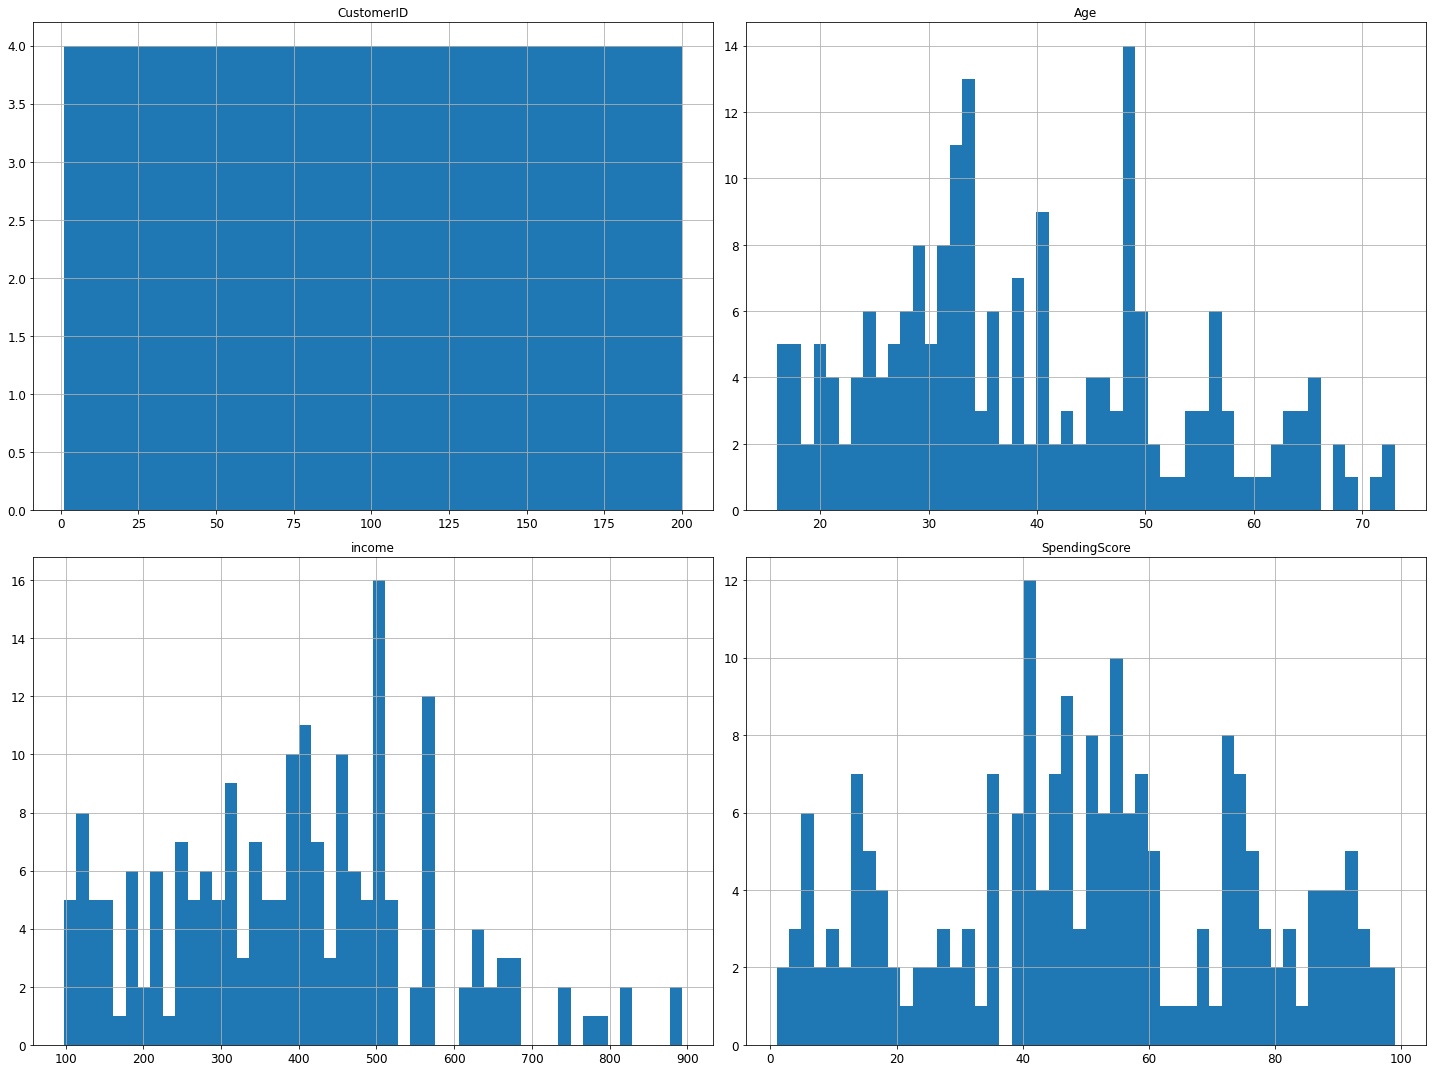

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
customer_data.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Saving figure scatter_matrix_plot


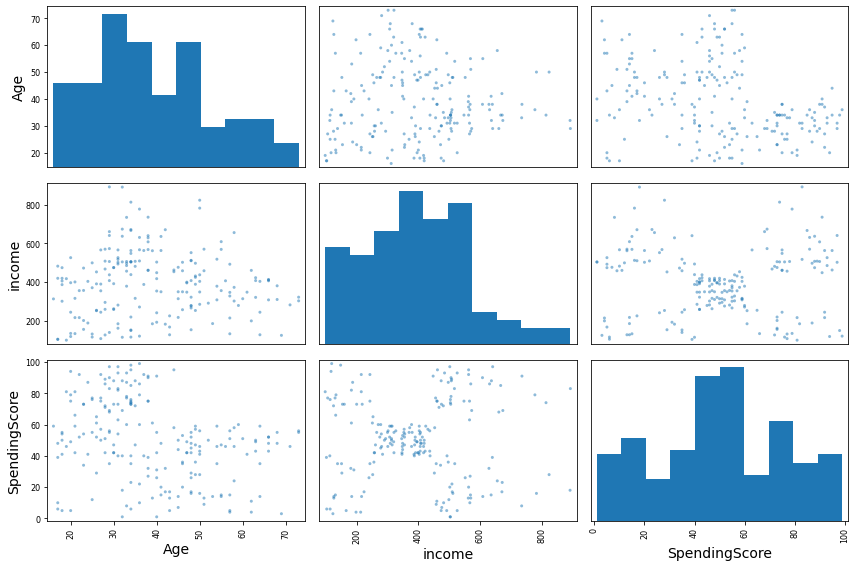

In [148]:
corr_matrix = customer_data.corr()
corr_matrix["SpendingScore"].sort_values(ascending=False)

from pandas.plotting import scatter_matrix
attributes = ["Age", "income", "SpendingScore"]
scatter_matrix(customer_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

## Observations and planning
Seen from the table, SpendingScore is the current evaluation of customers consumption level. Other than it, I'd like to find out if there's similarity among closing age, income and customer gender. So spendingScore would be dropped at the begining of the research. After the AI clustering, we may compare the average spending scores among different clusters

## Data Preparation

### Transfer Gender colum from string to number
As there are only 2 genders, use OrdinalEncoder instead of OneHot for simplification

In [149]:
customer_num = customer_data.drop("Gender", axis=1)

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

num_attribs = ["Age", "income"] #Remove CustomerId as it's a sequence has no meaning, remove SpendingScore not to affect the new model
cat_attribs = ["Gender"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

X = full_pipeline.fit_transform(customer_data)

## Clustering

K-Means algorithm is chonsen here because it's one of the fastest clustering algorithms, and also one of the simplest



### Finding the optimal number of clusters

In [151]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


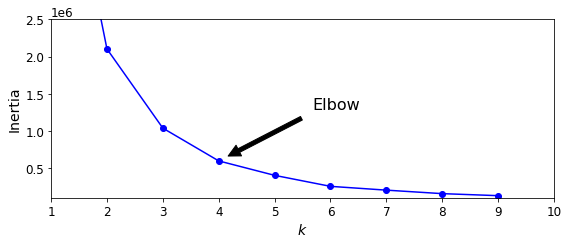

In [152]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 100000, 2500000])
save_fig("inertia_vs_k_plot")
plt.show()

As we can see, there is an elbow at  𝑘=4 , which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So  𝑘=4  is a pretty good choice. 

Let's try another approach - the _silhouette score_

In [153]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


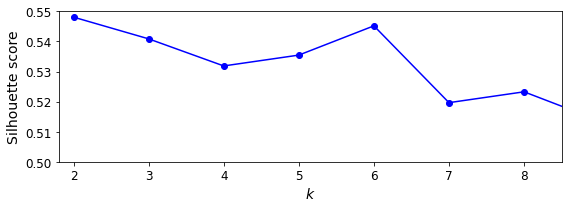

In [154]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.5, 0.55])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Seems that 4 is not bad, but clearly 6 is much better, looking further:

Saving figure silhouette_analysis_plot


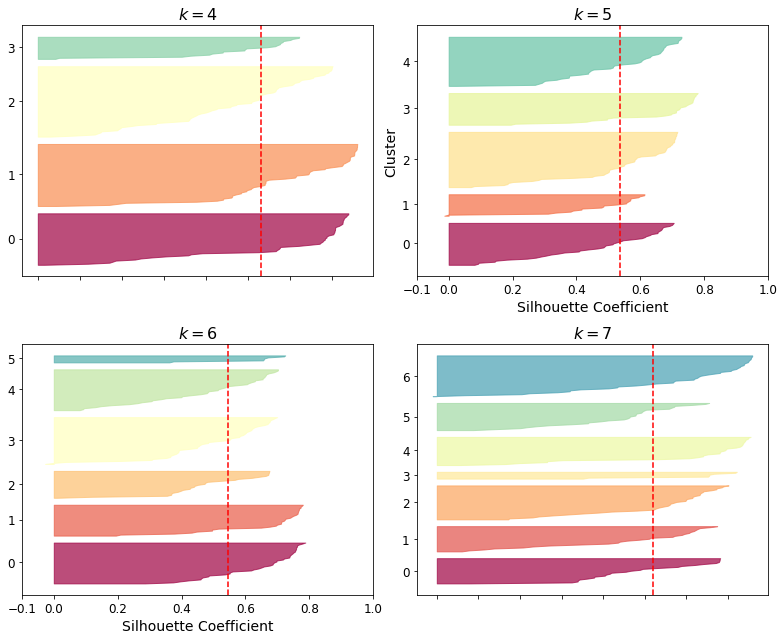

In [155]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (4, 5, 6, 7):
    plt.subplot(2, 2, k - 3)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

As we can see,  𝑘=5  looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

To solve the variability issue, we run it 10 times

In [156]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=42)
y_pred = kmeans_rnd_10_inits.fit_predict(X)

## Find meaning behind clusters

Calculate the average spending scores for each cluster

In [157]:
customer_data["cluster"] = y_pred #Assign new column to our data framework

In [158]:
customer_data.groupby('cluster'). mean()

,CustomerID,Age,income,SpendingScore
cluster,,,,
0,96.047619,43.666667,274.666667,50.666667
1,97.909091,38.090909,703.954545,52.000000
2,97.897959,41.469388,391.551020,49.897959
3,103.531250,34.687500,143.375000,49.656250
4,105.490909,36.509091,508.236364,49.709091


## Conclusion and suggestions
As seen from the last table, cluster 0 with highest average age and cluster 1 with highest average income have higher average SpendingScore. The future promotion should focus on customers who's profile fall into the cluster 0 or 1.